## 1.Import libraries
The required libraries for this notebook are pandas, sklearn, numpy and matplotlib.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
from tqdm.auto import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
import imgaug.augmenters as iaa
import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, metrics

## 2.1 Edit label.csv data
Add column for binary label: 0 for no tumor, 1 for tumor

In [2]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


## 2.2 Add image data
Add image data in the form of an array to the label data and save it in a new pickle file so it does not need to run everytime

In [3]:
def create_binary(df):
    '''
    Inputs
        df: Label data.

    Return
        binary: List of binary labels - 0 if no tumor, 1 if tumor.
    '''

    binary = []
    for label in df['label']:
        if 'no_tumor' in label:
            binary.append(0)
        else:
            binary.append(1)
    return binary

In [4]:
# data_path = './dataset/image'
# images = []
# for filename in tqdm(df['file_name']):
#     im = imread(os.path.join(data_path, filename), as_gray=True)
#     coeffs = pywt.dwt2(im, 'haar')
#     LL, (LH, HL, HH) = coeffs
#     # DWT transforms image to (256,256) from (516,516), also for denoising
#     images.append(LL)

# # Index of images with no_tumor label
# noTumor_idx = df.index[df['label'] == 'no_tumor'].tolist()
# # List of images with no_tumor label
# images_noTumor = []
# for idx in tqdm(noTumor_idx):
#     images_noTumor.append(images[idx])

# seq1 = iaa.Sequential([
#     iaa.Fliplr(0.5),  # horizontal flips
#     # Small gaussian blur with random sigma between 0 and 0.5.
#     # But we only blur about 50% of all images.
#     iaa.Sometimes(
#         0.5,
#         iaa.GaussianBlur(sigma=(0, 0.5))
#     )
# ], random_order=True)

# seq2 = iaa.Sequential([
#     iaa.Flipud(0.5),  # vertical flips
#     # Small gaussian blur with random sigma between 0 and 0.5.
#     # But we only blur about 50% of all images.
#     iaa.Sometimes(
#         0.5,
#         iaa.GaussianBlur(sigma=(0, 0.5))
#     )
# ], random_order=True)

# # Quadruple the no_tumor images
# images_aug_noTumor1 = seq1(images=images_noTumor)
# images_aug_noTumor2 = seq2(images=images_noTumor)

# # Concatenate the lists of image pixel data to form a new dataset with augmented images
# images_new = images + images_aug_noTumor1 + images_aug_noTumor2

In [5]:
def extract_hog(images_pixelData):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       hog_features: A list of HOG features for each image
    '''
    hog_features = []
    for i in tqdm(range(len(images_pixelData))):
        resized_im = resize(images_pixelData[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

if os.path.exists('./dataset/label_taskA_hog.pkl'):
    print('The pickle file for Task A with hog features data already exists')
else:
    binary = create_binary(df)
    hog_features = extract_hog(images_new)
    
    label_taskA = pd.DataFrame(data = hog_features)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx) 
    label_taskA.to_pickle("./dataset/label_taskA_hog.pkl")

The pickle file for Task A with hog features data already exists


In [6]:
def extract_lbp(images_pixelData, numPoints):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    radius = 3

    lbp_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)
        
        lbp_features.append(hist)
    return lbp_features

if os.path.exists('./dataset/label_taskA_lbp.pkl'):
    print('The pickle file for Task B with lbp features data already exists')
else:
    binary = create_binary(df)
    lbp_features = extract_lbp(images_new, 255)
    
    label_taskA = pd.DataFrame(data = lbp_features)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_lbp.pkl")

The pickle file for Task B with lbp features data already exists


In [8]:
def extract_multidwt(images_pixelData):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       multidwt: A list of Local Binary Pattern (LBP) features for each image
    '''
    multidwt = []
    for i in tqdm(range(len(images_pixelData))):
        # Second level DWT
        coeffs = pywt.dwt2(images_pixelData[i], 'haar')
        LL, (LH, HL, HH) = coeffs
        # Third level DWT
        coeffs2 = pywt.dwt2(LL, 'haar')
        LL2, (LH2, HL2, HH2) = coeffs2

        multidwt.append(LL2.ravel())

    return multidwt

if os.path.exists('./dataset/label_taskA_multidwt.pkl'):
    print('The pickle file for Task B image data transformed by DWT three times already exists')
else:
    binary = create_binary(df)
    multidwt = extract_multidwt(images_new)
    
    label_taskA = pd.DataFrame(data = multidwt)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_multidwt.pkl")

The pickle file for Task B image data transformed by DWT three times already exists


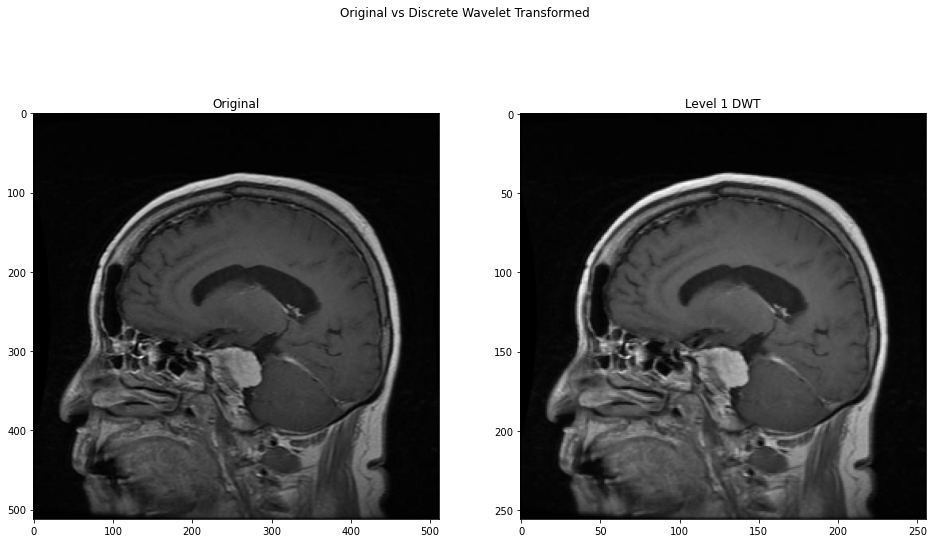

In [22]:
img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs
coeffs2 = pywt.dwt2(LL, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
# fig.suptitle('Original vs Discrete Wavelet Transformed')
axs[0].set_title('Original')
axs[0].imshow(img, cmap=plt.cm.gray)
axs[1].set_title('Level 1 DWT')
axs[1].imshow(LL, cmap=plt.cm.gray)

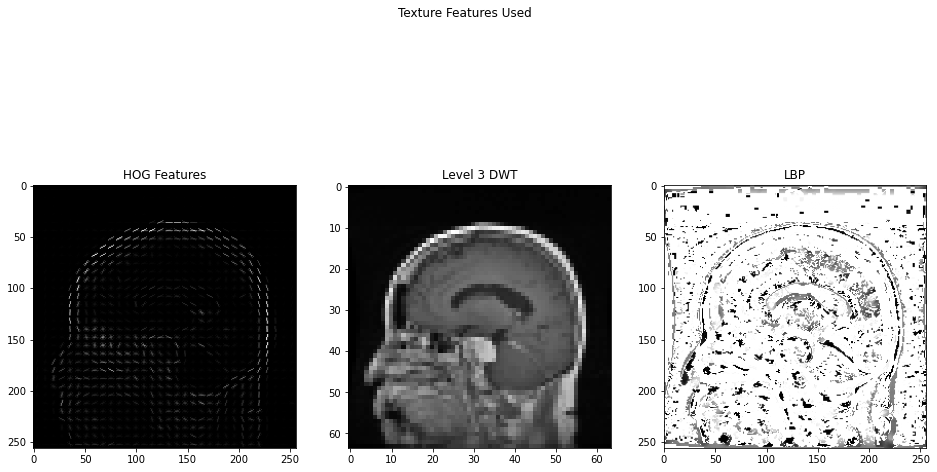

In [26]:
img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs

fd, hog_img = hog(LL, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = True, block_norm='L2-Hys')

coeffs3 = pywt.dwt2(LL2, 'haar')
LL3, (LH3, HL3, HH3) = coeffs3

lbp = local_binary_pattern(LL, 255, 8, method="uniform")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))
# fig.suptitle('Texture Features Used')
axs[0].set_title('HOG Features')
axs[0].imshow(hog_img, cmap=plt.cm.gray)

axs[1].set_title('Level 3 DWT')
axs[1].imshow(LL3, cmap=plt.cm.gray)

axs[2].set_title('LBP')
axs[2].imshow(lbp, cmap=plt.cm.gray)

In [20]:
feature = 'multidwt'

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskA = pd.read_pickle("./dataset/label_taskA_hog.pkl")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskA = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
# elif feature == 'canny':
#     # Doing classification with Canny filtered image data
#     label_taskA = pd.read_pickle("./dataset/label_taskA_canny.pkl")
elif feature == 'multidwt':
    # Doing classification with Multi-DWT image data
    label_taskA = pd.read_pickle("./dataset/label_taskA_multidwt.pkl")
elif feature == 'hoglbp':
    # Doing classification with image HOG and LBP features
    hog_features = pd.read_pickle("./dataset/label_taskA_hog.pkl")
    lbp_features = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
    # Concatenate tables column-wise and remove extra 'binary_label' column
    label_taskA = pd.concat(
        [hog_features.drop('binary_label', axis=1), lbp_features], axis=1)

X = label_taskA.drop('binary_label', axis=1)  # All other features
Y = label_taskA['binary_label']  # binary label

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=3, shuffle=True, stratify=Y)

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)), 3),
                                             round((len(y_test)*1.0)/len(X), 3)))

# the built-in function to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# fit scaler to training dataset
scaler.fit(X_train)
# transform training and test dataset with fitted scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape[1]} features before PCA')
# Sanity check
print(('Train set mean = {mean:.2f}, Train set var = {var:.2f}').format(
    mean=X_train.mean(), var=X_train.var()))

train set: 0.7  | test set: 0.3
4096 features before PCA
Train set mean = 0.00, Train set var = 1.00


In [6]:
# # GRIDSEARCHCV
# def SVMClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset.

#     Return
#         Y_pred: Predicted labels from X_test using SVM.
#     '''

#     # Create dictionary of parameters to cross validate the estimator on
#     # linear was considered in another function as kernel='linear' took very long to compute
#     parameters = [
#         {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
#          "pca__n_components": [0.95, 0.96, 0.97]},
#         {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3, 4],
#          "pca__n_components": [0.95, 0.96, 0.97]}
#     ]

#     matthews = metrics.make_scorer(metrics.matthews_corrcoef)
#     scoring = {'AUC': 'roc_auc', 'matthews': matthews}

#     pca = PCA()
#     # Create SVC object
#     svc = svm.SVC(probability=True)

#     pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(pca_svc,
#                        parameters,
#                        scoring=scoring,
#                        refit='matthews',  # use matthews for refit due to imbalanced data
#                        verbose=2,
#                        cv=3,
#                        n_jobs=1,
#                        return_train_score=True)
#     # Fit SVC model with the parameters for cross-validation
#     clf.fit(X_train, y_train)
#     # Predict labels with the best parameters from cross-validation
#     print(clf.best_params_)

#     results=pd.DataFrame.from_dict(clf.cv_results_).sort_values(
#         by = ['rank_test_matthews'])
#     results=results[['params', 'mean_train_AUC', 'mean_test_AUC', 'rank_test_AUC',
#                        'mean_train_matthews', 'mean_test_matthews', 'rank_test_matthews']]

#     # Predict labels with the best parameters from cross-validation
#     Y_pred=clf.predict(X_test)

#     fig, ax=plt.subplots()
#     metrics.ConfusionMatrixDisplay.from_predictions(
#         y_test,
#         Y_pred,
#         cmap = plt.cm.Blues,
#         normalize = 'true',
#         ax = ax,
#         display_labels = ['No tumor', 'Tumor']
#     )
#     ax.set_title('SVM Classifier')

#     return Y_pred, results

# Y_pred_SVM, results_SVM=SVMClassifierCV(X_train, y_train, X_test)
# print(metrics.classification_report(
#     y_test, Y_pred_SVM, target_names=['No tumor', 'Tumor']))
# display(results_SVM)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END pca__n_components=0.95, svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   6.3s
[CV] END pca__n_components=0.95, svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   6.8s
[CV] END pca__n_components=0.95, svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   6.8s
[CV] END pca__n_components=0.95, svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   8.5s
[CV] END pca__n_components=0.95, svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   8.7s
[CV] END pca__n_components=0.95, svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   9.0s
[CV] END pca__n_components=0.95, svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   7.1s
[CV] END pca__n_components=0.95, svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   7.1s
[CV] END pca__n_components=0.95, svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   7.2s
[CV] END pca__n_components=0.95, svc__C=10, svc__gamma=auto, svc_

ValueError: Invalid parameter degree for estimator Pipeline(steps=[('pca', PCA()), ('svc', SVC(probability=True))]). Check the list of available parameters with `estimator.get_params().keys()`.

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 42
max_resources_: 2735
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 42
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=-0.218) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.488) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__

[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale,

[CV 1/5] END pca__n_components=0.96, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.218) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.293) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.293) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=10, svc__degree=4, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=10, svc__degree=4, svc__gamma=scale, svc__kernel=poly;,

[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.775, test=0.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.818, test=0.000) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.218) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.378) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score

[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.218) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.378) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.378) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.218) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__ker

[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.655) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.488) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.218) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=-0.143) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly

[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.733) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.493) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.293) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.537) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.733) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kerne

[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.537) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.618) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.493) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.255) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kerne

[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.745) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.462) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.592) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.592) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.153) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.655) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_

[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.153) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.745) total time=   0.0s
----------
iter: 2
n_candidates: 18
n_resources: 168
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END pca__n_components=0.96, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.458) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.659) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.532) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.524)

[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.460) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.524) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.313) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.458) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.659) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.460) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kerne

[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.585) total time=   0.1s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.782) total time=   0.1s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.742) total time=   0.1s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.627) total time=   0.1s
[CV 1/5] END pca__n_components=0.96, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.729) total time=   0.1s
[CV 2/5] END pca__n_components=0.96, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.692) total time=   0.1s
[CV 3/5] END pca__n_components=0.96, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.810) total time

[CV 5/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.880) total time=   2.4s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.892) total time=   2.4s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.899) total time=   2.5s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.845) total time=   2.5s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.858) total time=   2.5s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.880) total time=   2.5s
----------
iter: 6
n_candidates: 2
n_resources: 2688
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__k

,params,mean_train_score,mean_test_score,rank_test_score
144,"{'pca__n_components': 0.97, 'svc__C': 100, 'sv...",1.000000,0.939435,1
143,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc...",1.000000,0.939435,1
142,"{'pca__n_components': 0.97, 'svc__C': 100, 'sv...",1.000000,0.874773,3
141,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc...",1.000000,0.874773,3
140,"{'pca__n_components': 0.96, 'svc__C': 100, 'sv...",1.000000,0.871550,5
...,...,...,...,...
29,"{'pca__n_components': 0.96, 'svc__C': 10, 'svc...",1.000000,0.000000,123
20,"{'pca__n_components': 0.96, 'svc__C': 1, 'svc_...",0.883706,0.000000,123
23,"{'pca__n_components': 0.96, 'svc__C': 1, 'svc_...",1.000000,0.000000,123
13,"{'pca__n_components': 0.98, 'svc__C': 1, 'svc_...",1.000000,0.000000,123


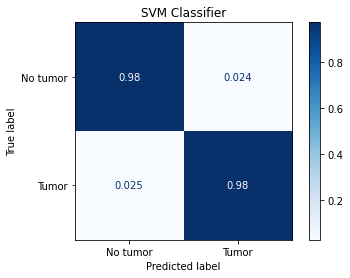

In [7]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.

    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    # linear was considered in another function as kernel='linear' took very long to compute
    parameters = [
        {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
         "pca__n_components": [0.96, 0.97, 0.98]},
        {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3, 4],
         "pca__n_components": [0.96, 0.97, 0.98]}
    ]

    matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()
    # Create SVC object
    svc = svm.SVC(probability=True)

    pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_svc,
                              parameters,
                              factor=2,
                              scoring=matthews,
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('SVM Classifier')

    return Y_pred, results


Y_pred_SVM, results_SVM = SVMClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_SVM, target_names=['No tumor', 'Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_SVM)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 21
max_resources_: 2735
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 153
n_resources: 21
Fitting 5 folds for each of 153 candidates, totalling 765 fits
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=-0.577) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.577) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=-0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(tra

[CV 5/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.378, test=-0.333) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.509, test=-0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.630, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.492, test=-0.577) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.500, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.378, test=-0.333) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.98;, score=(train=0.509, test=-0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.98;, score=(train=0.630, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.98;, score=(train=0.492, test=-0.577) total time=   

[CV 1/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.683, test=-0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.364, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.429, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.258, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.655, test=1.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=12, pca__n_components=0.96;, score=(train=0.333, test=0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=12, pca__n_components=0.96;, score=(train=0.323, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=12, pca__n_components=0.96;, score=(train=0.618, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.96;, score=(train=0.516, test=0.000) total time

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 1/5] END neigh__n_neighbors=17, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=17, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=17, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=17, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=17, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=17, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=17, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=17, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=17, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 2/5] END neigh__n_neighbors=18, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=18, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=18, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=18, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=19, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=19, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=19, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=19, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=19, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=21, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=23, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 4/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=25, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=25, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=26, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=28, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 2/5] END neigh__n_neighbors=30, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=30, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=30, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=30, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=30, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=30, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=30, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=30, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=30, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=31, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=32, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=32, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=32, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=32, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=32, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=32, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=32, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=32, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=33, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=33, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=33, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=33, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=33, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=33, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=34, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=34, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=34, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=35, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=35, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=35, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=35, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=35, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=35, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=35, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=35, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=35, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 1/5] END neigh__n_neighbors=37, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=37, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=37, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=37, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=37, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=37, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=37, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=37, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=37, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=38, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=38, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=38, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=38, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=38, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=38, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=39, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=39, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=39, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=40, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=40, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=40, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=40, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=40, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=40, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=40, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=40, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=40, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=41, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=42, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=42, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=42, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=42, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=42, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=42, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=42, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=42, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 1/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=45, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=45, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=45, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=45, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=45, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=45, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 4/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=47, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=47, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 4/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=49, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=49, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 4/5] END neigh__n_neighbors=50, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=50, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=50, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=50, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 3/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
----------
iter: 1
n_candidates: 77
n_resources: 42
Fitting 5 folds for each of 77 candidates, totalling 385 fits
[CV 1/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=50, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 2/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 2/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=48, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 1/5] END neigh__n_neighbors=47, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=47, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=47, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=47, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=47, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=47, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=47, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=47, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=47, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 4/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=47, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=46, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=46, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=46, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 3/5] END neigh__n_neighbors=46, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=46, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=46, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=45, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=45, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 2/5] END neigh__n_neighbors=45, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=45, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=45, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=45, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=44, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=44, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=44, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=44, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=44, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 2/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=43, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighb

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 3/5] END neigh__n_neighbors=34, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=34, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=34, pca__n_components=0.97;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=26, pca__n_components=0.97;, score=(train=0.481, test=0.447) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=26, pca__n_components=0.97;, score=(train=0.296, test=1.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=26, pca__n_components=0.97;, score=(train=0.346, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=26, pca__n_components=0.97;, score=(train=0.577, test=1.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=26, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=33, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 

[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.392, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.594, test=-0.149) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.516, test=1.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.671, test=-0.333) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.699, test=0.488) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.392, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=19, pca__n_components=0.98;, score=(train=0.640, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=19, pca__n_components=0.98;, score=(train=0.454, test=1.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=19, pca__n_components=0.98;, score=(train=0.568, test=-0.333) total ti

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 4/5] END neigh__n_neighbors=34, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=34, pca__n_components=0.96;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=0.456, test=0.577) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=0.206, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=0.346, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=0.416, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=25, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=25, pca__n_components=0.98;, score=(train=0.520, test=0.577) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=25, pca__n_components=0.98;, score=(train=0.206, test=0.000) total time=   0.0s


[CV 2/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=0.329, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=29, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=0.429, test=0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=0.296, test=1.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=0.346, test=-0.218) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=0.583, test=-0.143) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=28, pca__n_components=0.98;, score=(train=0.000, test=0.000) total tim

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 3/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=0.346, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=0.472, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=25, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=51, pca__n_components=0.98;, score=(train=nan, test=nan) total time=   0.0s
----------
iter: 2
n_candidates: 39
n_resources: 84
Fitting 5 folds for each of 39 candidates, totalling 195 fits
[CV 1/5] E

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\utils\meta

[CV 5/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.577, test=0.149) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=23, pca__n_components=0.96;, score=(train=0.497, test=0.092) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=23, pca__n_components=0.96;, score=(train=0.388, test=0.333) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=23, pca__n_components=0.96;, score=(train=0.583, test=0.405) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=23, pca__n_components=0.96;, score=(train=0.530, test=-0.098) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=23, pca__n_components=0.96;, score=(train=0.606, test=0.234) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=23, pca__n_components=0.97;, score=(train=0.532, test=0.092) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=23, pca__n_components=0.97;, score=(train=0.353, test=0.333) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=23, pca__n_components=0.97;, score=(train=0.552, test=0.405) total time

[CV 1/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=0.201, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=0.385, test=-0.324) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=0.509, test=0.153) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=49, pca__n_components=0.98;, score=(train=0.315, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=0.201, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=0.449, test=-0.255) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=49, pca__n_components=0.97;, score=(train=0.536, test=0.153) total tim

[CV 5/5] END neigh__n_neighbors=44, pca__n_components=0.98;, score=(train=0.409, test=0.447) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=44, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=44, pca__n_components=0.97;, score=(train=0.253, test=0.592) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=44, pca__n_components=0.97;, score=(train=0.526, test=-0.078) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=44, pca__n_components=0.97;, score=(train=0.419, test=-0.153) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=44, pca__n_components=0.97;, score=(train=0.379, test=0.447) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=0.292, test=0.592) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=44, pca__n_components=0.96;, score=(train=0.583, test=-0.164) total ti

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06666667 -0.06666667 -0.13333333  0.13333333 -0.18213672 -0.18213672
 -0.18213672 -0.13333333 -0.24880339 -0.11547005 -0.29760677 -0.34641016
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.24880339 -0.24880339
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.2        -0.24880339
  0.         -0.06666667 -0.06666667 -0.06666667 -0.13333333 -0.01786328
 -0.06666667 -0.06666667  0.13333333  0.18213672  0.11547005  0.11547005
  0.26666667  0.26666667  0.26666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

[CV 1/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=0.641, test=0.100) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=0.571, test=0.628) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=0.633, test=0.322) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=0.630, test=0.571) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=48, pca__n_components=0.98;, score=(train=0.371, test=0.007) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.635, test=0.500) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.629, test=0.448) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.624, test=0.401) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.666, test=0.492) total time=

[CV 4/5] END neigh__n_neighbors=26, pca__n_components=0.98;, score=(train=0.635, test=0.454) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=26, pca__n_components=0.98;, score=(train=0.688, test=0.398) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.671, test=0.500) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.603, test=0.448) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.641, test=0.401) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.666, test=0.492) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.706, test=0.398) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.671, test=0.500) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.616, test=0.517) total time=

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06666667 -0.06666667 -0.13333333  0.13333333 -0.18213672 -0.18213672
 -0.18213672 -0.13333333 -0.24880339 -0.11547005 -0.29760677 -0.34641016
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.24880339 -0.24880339
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.2        -0.24880339
  0.         -0.06666667 -0.06666667 -0.06666667 -0.13333333 -0.01786328
 -0.06666667 -0.06666667  0.13333333  0.18213672  0.11547005  0.11547005
  0.26666667  0.26666667  0.26666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 4
n_candidates: 10
n_resources: 336
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.694, test=0.549) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.684, test=0.723) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.686, test=0.585) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.761, test=0.742) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.763, test=0.627) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.694, test=0.549) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.693, test=0.723) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.709, test=0.617) total tim

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06666667 -0.06666667 -0.13333333  0.13333333 -0.18213672 -0.18213672
 -0.18213672 -0.13333333 -0.24880339 -0.11547005 -0.29760677 -0.34641016
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.24880339 -0.24880339
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.2        -0.24880339
  0.         -0.06666667 -0.06666667 -0.06666667 -0.13333333 -0.01786328
 -0.06666667 -0.06666667  0.13333333  0.18213672  0.11547005  0.11547005
  0.26666667  0.26666667  0.26666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.694, test=0.636) total time=   0.4s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.718, test=0.745) total time=   0.4s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.721, test=0.576) total time=   0.4s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.787, test=0.666) total time=   0.4s
[CV 5/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.725, test=0.583) total time=   0.4s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.698, test=0.618) total time=   0.5s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.722, test=0.745) total time=   0.4s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.705, test=0.525) total time=   0.4s
[CV 4/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.779, test=0.666) total time=

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06666667 -0.06666667 -0.13333333  0.13333333 -0.18213672 -0.18213672
 -0.18213672 -0.13333333 -0.24880339 -0.11547005 -0.29760677 -0.34641016
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.24880339 -0.24880339
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.2        -0.24880339
  0.         -0.06666667 -0.06666667 -0.06666667 -0.13333333 -0.01786328
 -0.06666667 -0.06666667  0.13333333  0.18213672  0.11547005  0.11547005
  0.26666667  0.26666667  0.26666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

[CV 1/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.712, test=0.734) total time=   1.6s
[CV 2/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.730, test=0.771) total time=   1.6s
[CV 3/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.731, test=0.669) total time=   1.6s
[CV 4/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.760, test=0.695) total time=   1.6s
[CV 5/5] END neigh__n_neighbors=23, pca__n_components=0.98;, score=(train=0.745, test=0.701) total time=   1.6s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.721, test=0.771) total time=   1.6s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.730, test=0.771) total time=   1.7s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.729, test=0.669) total time=   1.6s
[CV 4/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.760, test=0.703) total time=

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06666667 -0.06666667 -0.13333333  0.13333333 -0.18213672 -0.18213672
 -0.18213672 -0.13333333 -0.24880339 -0.11547005 -0.29760677 -0.34641016
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.24880339 -0.24880339
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.2        -0.24880339
  0.         -0.06666667 -0.06666667 -0.06666667 -0.13333333 -0.01786328
 -0.06666667 -0.06666667  0.13333333  0.18213672  0.11547005  0.11547005
  0.26666667  0.26666667  0.26666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.743, test=0.748) total time=   5.6s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.760, test=0.759) total time=   5.7s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.753, test=0.740) total time=   5.7s
[CV 4/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.759, test=0.731) total time=   5.7s
[CV 5/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.762, test=0.730) total time=   5.5s
[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.751, test=0.756) total time=   5.8s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.775, test=0.755) total time=   5.8s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.765, test=0.745) total time=   5.7s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.97;, score=(train=0.769, test=0.744) total time=

C:\Users\tanpi\miniconda3\envs\amls-cw\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06666667 -0.06666667 -0.13333333  0.13333333 -0.18213672 -0.18213672
 -0.18213672 -0.13333333 -0.24880339 -0.11547005 -0.29760677 -0.34641016
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.24880339 -0.24880339
 -0.13333333 -0.13333333 -0.13333333 -0.2        -0.2        -0.24880339
  0.         -0.06666667 -0.06666667 -0.06666667 -0.13333333 -0.01786328
 -0.06666667 -0.06666667  0.13333333  0.18213672  0.11547005  0.11547005
  0.26666667  0.26666667  0.26666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

{'neigh__n_neighbors': 22, 'pca__n_components': 0.97}
              precision    recall  f1-score   support

    No tumor       0.84      0.81      0.83       409
       Tumor       0.90      0.92      0.91       764

    accuracy                           0.88      1173
   macro avg       0.87      0.86      0.87      1173
weighted avg       0.88      0.88      0.88      1173



,params,mean_train_score,mean_test_score,rank_test_score
308,"{'neigh__n_neighbors': 22, 'pca__n_components': 0.97}",0.765502,0.750490,1
307,"{'neigh__n_neighbors': 24, 'pca__n_components': 0.97}",0.755460,0.741587,2
306,"{'neigh__n_neighbors': 22, 'pca__n_components': 0.97}",0.744591,0.729352,3
305,"{'neigh__n_neighbors': 24, 'pca__n_components': 0.97}",0.737176,0.721424,4
304,"{'neigh__n_neighbors': 23, 'pca__n_components': 0.98}",0.735727,0.713938,5
...,...,...,...,...
108,"{'neigh__n_neighbors': 37, 'pca__n_components': 0.96}",NaN,NaN,305
107,"{'neigh__n_neighbors': 36, 'pca__n_components': 0.98}",NaN,NaN,306
106,"{'neigh__n_neighbors': 36, 'pca__n_components': 0.97}",NaN,NaN,307
172,"{'neigh__n_neighbors': 44, 'pca__n_components': 0.96}",NaN,NaN,308


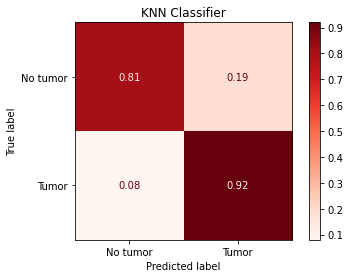

In [11]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;

    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = {'neigh__n_neighbors': range(1, math.floor(math.sqrt(X_train.shape[0])), 1),
                  "pca__n_components": [0.96, 0.97, 0.98]}

    matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()

    # Create KNN object
    neigh = KNeighborsClassifier(algorithm='auto')

    pca_neigh = Pipeline(steps=[('pca', pca), ('neigh', neigh)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_neigh,
                              parameters,
                              factor=2,
                              scoring=matthews,
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(neigh,
#                        parameters,
#                        scoring=scoring,
#                        refit='matthews', # use matthews for refit due to imbalanced data
#                        cv=3,
#                        verbose=1,
#                        return_train_score=True)

    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Reds,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('KNN Classifier')

    return Y_pred, results


Y_pred_KNN, results_KNN = KNNClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_KNN, target_names=['No tumor', 'Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_KNN)

In [ ]:
# def RFClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset;
#         k: Number of trees in the forest.
        
#     Return
#         Y_pred: Predicted labels from X_test using Random Forests.
#     '''
#     # Create dictionary of parameters to cross validate the estimator on
#     parameters = {'n_estimators':[100, 200, 300], 'criterion':['entropy', 'gini'],
#     'max_features': ['sqrt', 'log2']}
#     # Create Random Forest object
#     RF = RandomForestClassifier()
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(RF, parameters, scoring='accuracy')
#     # Fit RF model with the parameters for cross-validation
#     clf.fit(X_train, y_train) 
#     print(clf.best_params_)
#     # Predict labels with the best parameters from cross-validation
#     Y_pred = clf.predict(X_test)

#     disp = metrics.ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         cmap=plt.cm.Greens,
#         normalize='true'
#     )
#     disp.ax_.set_title('Random Forest Classifier')
    
#     return Y_pred, disp

# Y_pred_RandomForest, disp_RF = RFClassifierCV(X_train, y_train, X_test)
# score_RandomForest = metrics.accuracy_score(y_test, Y_pred_RandomForest)
# print('Random Forest classifier score:', score_RandomForest)